In [1]:
# Please run this cell for custom formating of notebook cells
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

* Python        3.5.2
* Cython        0.24.1
* Numpy         1.14.2
* Pandas        0.20.3
* Scikit Learn  0.14.1
* Scipy         1.0.1
* Seaborn       0.8.1



### Table Of Contents

* Introduction
* Loading packages
* Loading datasets
* Data Exploration/Analysis
* Data cleaning and preprocessing
* Machine Learning algorithms brawl (Base and Ensemble models)
* Algorithm tuning
* Ensembles
* Saving the model
* Making submissions




### Introduction

### Loading Packages

In [2]:
# here's several helpful packages to load in 

import numpy as np
import pandas as pd
from pandas import set_option
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold,GridSearchCV, cross_val_score
from sklearn.metrics import classification_report ,confusion_matrix ,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes  import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier,ExtraTreesClassifier
import sys
from IPython.display import display

### Load the dataset

In [4]:
# Function that returns the size of an object in MB
def size(obj):
    return "{0:.2f} MB".format(sys.getsizeof(obj) / (1000 * 1000))

In [5]:
telco = pd.read_csv("data\Churn_trian.csv", index_col=None,  na_values=["MISSINGVAL", 'NA','?'])
test = pd.read_csv('data\Churn_test.csv',index_col=None,  na_values=["MISSINGVAL", 'NA','?'])
print('telco -- dimensions: {0};   size: {1}'.format(telco.shape, size(telco)))
print('test -- dimensions: {0};   size: {1}'.format(test.shape, size(test)))


telco -- dimensions: (5298, 25);   size: 3.92 MB
test -- dimensions: (1769, 24);   size: 1.25 MB


In [6]:
set_option('display.max_rows', 500 )
set_option('display.width', 100)
set_option('precision', 3)

### Data Exploration/Analysis

In [7]:
# Head
telco.head(3)

,CustomerID,Country,State,Retired,HasPartner,HasDependents,Education,Gender,BaseCharges,DOC,...,Multilines,OnlineBackup,InternetServiceCategory,StreamingMovies,OnlineSecurity,DeviceProtection,StreamingTelevision,HasPhoneService,TechnicalSupport,Churn
0,Cust1201,India,Maharashtra,0,2,2,Masters,Male,478.50,5-1-2012,...,No,No,Fiber optic,Yes,No,Yes,Yes,1,No,No
1,Cust1202,India,Maharashtra,0,2,2,ProfessionalQalification,Male,103.25,5-1-2012,...,No,No internet service,No,No internet service,No internet service,No internet service,No internet service,1,No internet service,No
2,Cust1203,India,Maharashtra,0,2,2,ProfessionalQalification,Male,399.75,5-1-2012,...,No,No,Fiber optic,Yes,No,No,No,1,No,No


In [8]:
# some info please
print(telco.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5298 entries, 0 to 5297
Data columns (total 25 columns):
CustomerID                 5298 non-null object
Country                    5293 non-null object
State                      5290 non-null object
Retired                    5298 non-null int64
HasPartner                 5298 non-null int64
HasDependents              5298 non-null int64
Education                  5288 non-null object
Gender                     5294 non-null object
BaseCharges                5298 non-null float64
DOC                        5298 non-null object
TotalCharges               5288 non-null float64
DOE                        5298 non-null object
ElectronicBilling          5298 non-null object
ContractType               5293 non-null object
PaymentMethod              5298 non-null object
Multilines                 5298 non-null object
OnlineBackup               5298 non-null object
InternetServiceCategory    5298 non-null object
StreamingMovies            529

from the result, it is clear that alot of features need to be converted to numeric form for the machine learning algorithms to function hitch-free

In [9]:
# Checking for variables with missing values in descending order
telco.isnull().sum().sort_values(ascending=False)

Education                  10
TotalCharges               10
State                       8
Country                     5
ContractType                5
Gender                      4
Churn                       0
DOE                         0
Retired                     0
HasPartner                  0
HasDependents               0
BaseCharges                 0
DOC                         0
ElectronicBilling           0
TechnicalSupport            0
PaymentMethod               0
Multilines                  0
OnlineBackup                0
InternetServiceCategory     0
StreamingMovies             0
OnlineSecurity              0
DeviceProtection            0
StreamingTelevision         0
HasPhoneService             0
CustomerID                  0
dtype: int64

As seen, there are few features with missing values. i'll fill in the missing values with the appriate strategy later on

In [10]:
# Checking and visualizing target class distribution
telco.Churn.value_counts(normalize=True)

No     0.75
Yes    0.25
Name: Churn, dtype: float64

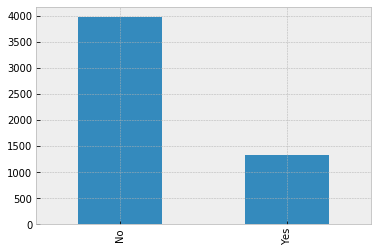

In [11]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline
telco.Churn.value_counts().plot(kind='bar')

There is visible class imbalance here. Therefore, in order to prevent the model from being biased in favour of the majority class, i will oversample the minority class and undersample the majority class using the SMOTEN library

In [12]:
floats = telco.select_dtypes(include=['float', 'int'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x086D6110>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x08741E70>]], dtype=object)

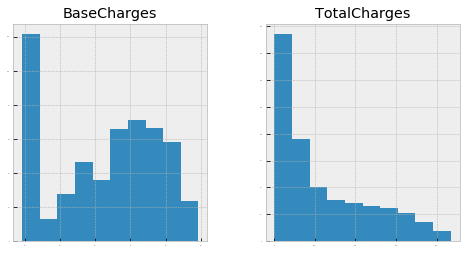

In [13]:
# histograms 
floats.hist(sharex=False, sharey = False, xlabelsize=1, ylabelsize=1, figsize=(8,4))

In [14]:
floats.describe().T

,count,mean,std,min,25%,50%,75%,max
BaseCharges,5298.0,325.467,151.353,91.25,178.250,352.5,451.250,593.75
TotalCharges,5288.0,11928.354,11486.453,94.25,2314.938,7377.5,19992.812,43424.00


The TotalCharges feature has a clear asymmetric distribution and both numerical features have very wide range in their values. The machine learning models will definately benefit from standardizing this features.

In [15]:
# Statistical summary of categorical features
set_option('precision', 3)
telco.describe(include=[np.object, pd.Categorical]).T

,count,unique,top,freq
CustomerID,5298,5298,Cust1555,1
Country,5293,1,India,5293
State,5290,1,Maharashtra,5290
Education,5288,5,Highschool or below,1426
Gender,5294,2,Male,2656
DOC,5298,1,5-1-2012,5298
DOE,5298,73,6-Dec-11,423
ElectronicBilling,5298,2,Yes,3120
ContractType,5293,3,Month-to-month,2779
PaymentMethod,5298,4,Electronic check,1586


### Data Preprocessing and Cleaning

#### Missing Values

Now we can tackle the issue with the TotalCharges features missing values. I will create an array that contains random numbers, which are computed based on the mean Total charge value in regards to the standard deviation and is_null

In [16]:
data = [telco, test]

for dataset in data:
    mean = telco["TotalCharges"].mean()
    std = test["TotalCharges"].std()
    is_null = dataset["TotalCharges"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_charge = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Totalcharges column with random values generated
    charges = dataset["TotalCharges"].copy()
    charges[np.isnan(charges)] = rand_charge
    dataset["TotalCharges"] = charges

In [17]:
# filling Gender, ContractType, Education
data = [telco, test]
for dataset in data:
    dataset.Gender.fillna('Male', inplace=True)
    dataset.ContractType.fillna('Month-to-month',inplace=True)
    dataset.Education.fillna('Other', inplace=True)

#### Dropping non informative features

In [18]:
data = [telco, test]
for dataset in data:
        dataset.drop(['Country','State','CustomerID'], axis=1, inplace=True)

#### Label Encoding

In [19]:
# Education
data = [telco, test]
for dataset in data:
    cadre = {"Highschool or below": 1, "Graduation": 2, "ProfessionalQalification": 3, "Masters": 4, "Other": 5}
    dataset['Education'] = dataset['Education'].map(cadre)


In [20]:
telco.Gender.value_counts()

Male      2660
Female    2638
Name: Gender, dtype: int64

In [21]:
# Gender
data = [telco, test]
for dataset in data:
    gender = {"Male": 1, "Female": 0}
    dataset['Gender'] = dataset['Gender'].map(gender)

#### Converting to datetime object

In [22]:
for dataset in data:
    dataset['DOE'] = pd.to_datetime(dataset['DOE'], dayfirst=True)
    dataset['DOC'] = pd.to_datetime(dataset['DOC'],dayfirst=True)

#### Creating a new feature to capture the timedelta between DOE and DOC

In [23]:
for dataset in data:
    dataset['Duration'] = dataset['DOC'] - dataset['DOE']

In [24]:
telco.head()

,Retired,HasPartner,HasDependents,Education,Gender,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,...,OnlineBackup,InternetServiceCategory,StreamingMovies,OnlineSecurity,DeviceProtection,StreamingTelevision,HasPhoneService,TechnicalSupport,Churn,Duration
0,0,2,2,4,1,478.50,2012-01-05,5920.00,2011-01-10,No,...,No,Fiber optic,Yes,No,Yes,Yes,1,No,No,360 days
1,0,2,2,3,1,103.25,2012-01-05,103.25,2011-12-06,No,...,No internet service,No,No internet service,No internet service,No internet service,No internet service,1,No internet service,No,30 days
2,0,2,2,3,1,399.75,2012-01-05,5217.00,2011-01-10,Yes,...,No,Fiber optic,Yes,No,No,No,1,No,No,360 days
3,0,2,1,3,1,324.75,2012-01-05,22757.50,2006-04-06,No,...,Yes,DSL,No,Yes,No,No,1,Yes,No,2100 days
4,0,2,2,3,0,372.50,2012-01-05,372.50,2011-12-06,Yes,...,No,Fiber optic,No,No,No,No,1,No,Yes,30 days


Now i have to convert the newly created 'Duration' feature to numeric datatype

In [25]:
telco['Duration'] = pd.to_numeric(telco['Duration'])

In [26]:
test['Duration'] = pd.to_numeric(test['Duration'])

In [27]:
# some info again for sanity check
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5298 entries, 0 to 5297
Data columns (total 23 columns):
Retired                    5298 non-null int64
HasPartner                 5298 non-null int64
HasDependents              5298 non-null int64
Education                  5298 non-null int64
Gender                     5298 non-null int64
BaseCharges                5298 non-null float64
DOC                        5298 non-null datetime64[ns]
TotalCharges               5298 non-null float64
DOE                        5298 non-null datetime64[ns]
ElectronicBilling          5298 non-null object
ContractType               5298 non-null object
PaymentMethod              5298 non-null object
Multilines                 5298 non-null object
OnlineBackup               5298 non-null object
InternetServiceCategory    5298 non-null object
StreamingMovies            5298 non-null object
OnlineSecurity             5298 non-null object
DeviceProtection           5298 non-null object
StreamingTelevis

I can now do away with both DOC and DOE

In [28]:
for dataset in data:
    dataset.drop(['DOC','DOE'], axis=1, inplace=True)

#### Label Ecoding

In [29]:
telco.ElectronicBilling.value_counts()

Yes    3120
No     2178
Name: ElectronicBilling, dtype: int64

In [30]:
# ElectronicBilling
for dataset in data:
    billing = {"Yes": 1, "No": 0}
    dataset['ElectronicBilling'] = dataset['ElectronicBilling'].map(billing)

In [31]:
# churn
churnn = {"Yes": 1, "No": 0}
telco['Churn'] = telco['Churn'].map(churnn)

Here i will be seperating the target class from the rest of the features

In [32]:
telco_data = telco.drop('Churn', axis=1)
churn = telco['Churn']

#### Transformation

Applying logarithm transformation to the TotalCharges feature which has a very strong right skew.

In [33]:
data =[telco_data,test]
for dataset in data:
    vals = dataset['TotalCharges'].values
    dataset['TotalCharges'] = np.log(vals+1)    

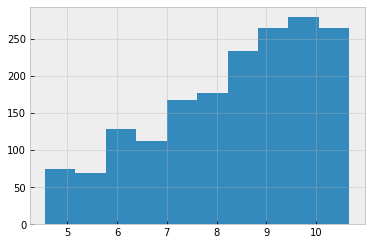

In [34]:
test['TotalCharges'].hist()

#### Dummy encoding nominal features

In [35]:
telco_dummies = pd.get_dummies(telco_data)
test_dummies = pd.get_dummies(test)

In [36]:
print('train: {0}, test: {1}'.format(telco_dummies.shape, test_dummies.shape))

train: (5298, 41), test: (1769, 40)


There is a feature missing in the test set. Therefore, i will compare coulumn names of the training and test set to check for disparity, then append the new feature to the test set populating it with zeros

In [37]:
test_dummies.columns

Index(['Retired', 'HasPartner', 'HasDependents', 'Education', 'Gender', 'BaseCharges',
       'TotalCharges', 'ElectronicBilling', 'HasPhoneService', 'Duration',
       'ContractType_Month-to-month', 'ContractType_One year', 'ContractType_Two year',
       'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Electronic check',
       'PaymentMethod_Mailed check', 'Multilines_No', 'Multilines_No phone service',
       'Multilines_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'InternetServiceCategory_DSL', 'InternetServiceCategory_Fiber optic',
       'InternetServiceCategory_No', 'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'StreamingTelevision_No', 'StreamingTelevision_No internet service',
       'StreamingTelevisi

In [38]:
telco_dummies.columns

Index(['Retired', 'HasPartner', 'HasDependents', 'Education', 'Gender', 'BaseCharges',
       'TotalCharges', 'ElectronicBilling', 'HasPhoneService', 'Duration',
       'ContractType_Month-to-month', 'ContractType_One year', 'ContractType_Two year',
       'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'Multilines_No',
       'Multilines_No phone service', 'Multilines_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'InternetServiceCategory_DSL',
       'InternetServiceCategory_Fiber optic', 'InternetServiceCategory_No', 'StreamingMovies_No',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'StreamingTelevision_No',
       'StreamingTelevision

In [39]:
test_dummies['PaymentMethod_Credit card (automatic)'] = np.zeros_like(test_dummies['PaymentMethod_Bank transfer (automatic)'])

In [40]:
# now checking 
test_dummies.shape

(1769, 41)

I have a hunch that a positive correlation exists between Duration and TotalCharges. Since intution suggests that charges accumulate with time. i am going to investigate this assumption by creating a scatter plot and constructing a correlation matrix of both variables of interest

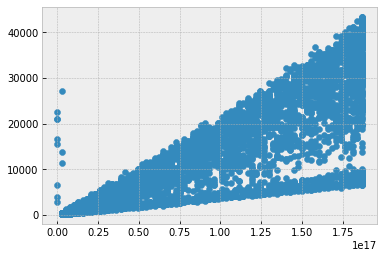

In [41]:
plt.scatter(telco['Duration'], telco['TotalCharges'])

In [42]:
suspect = telco.loc[:,['Duration','TotalCharges']]

In [43]:
print(suspect.corr(method='pearson'))

              Duration  TotalCharges
Duration         1.000         0.818
TotalCharges     0.818         1.000


Aha! I was right. now, i can safely drop one to prevent multicollinearity issues

In [44]:
data = [telco_dummies, test_dummies]
for dataset in data:
    dataset.drop('Duration', axis=1, inplace=True)

In [45]:
# Another sanity check
print('telco: {0}, test {1}'.format(telco_dummies.shape, test_dummies.shape))

telco: (5298, 40), test (1769, 40)


#### Spliting into train (80%) and validation set(20%)

In [47]:
X = telco_dummies.values
y = churn.values
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=.20, random_state=0)

#### Handling class imbalance

In [48]:
# Handling Target class imbalance by combination of over-sampling and under-sampling using the imbalance-learn SMOTEENN module
from collections import Counter
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_sample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 1683), (1, 2663)]


#### instantiating number of folds for cross validation, random seed and scoring metric

In [51]:
num_folds= 10
seed = 0
scoring = 'accuracy'

### Machine Learning Brawl

#### Building pipelines for scaling and model instantiation

In [49]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression())])))
pipelines.append(('ScaledSVM', Pipeline([('scaler', StandardScaler()),('SVM', SVC())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))

#### Evaluate Algorithms

The algorithms all use default tuning parameters. Let's compare the algorithms. We will display the mean and standard deviation of accuracy for each algorithm as we calculate it and collect the results for use later.

In [52]:
results = []
names = []
for name, model in pipelines:
    kfold= KFold(n_splits=num_folds, random_state=0)
    cv_results = cross_val_score(model,X_resampled, y_resampled, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{0}:{1:.4f}({2:.4f})'.format(name, cv_results.mean(), cv_results.std()))

ScaledLR:0.9103(0.0335)
ScaledSVM:0.9416(0.0412)
ScaledKNN:0.9099(0.0889)
ScaledCART:0.9273(0.0439)
ScaledNB:0.8884(0.0397)


The results suggest That Logistic Regression, Decision tree and SVM may be worth further study.
These are just mean accuracy values. It is always wise to look at the distribution of accuracy values calculated across cross validation folds. We can do that graphically using box and whisker
plots

[Text(0,0,'ScaledLR'),
 Text(0,0,'ScaledSVM'),
 Text(0,0,'ScaledKNN'),
 Text(0,0,'ScaledCART'),
 Text(0,0,'ScaledNB')]

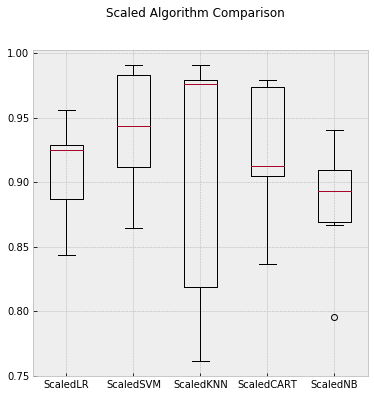

In [53]:
# visualization of individual performance
fig = plt.figure(figsize=(6,6))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

The results show a tight distribution for Logistic Regression which is encouraging, suggesting low variance.
The poor results for KNN are surprising. The results suggest digging deeper into the SVM and logistic regression algorithms. It is very likely that coniguration beyond the default may yield even more accurate models.

### Algorithm Tuning

#### Hyper parameter tuning of logistic regression model

I start of by tuning the regularization parameter C for LogisticRegressin. The default C value 
is 1.0. Below i try multiples of 10 between 0.0001 and 1000, covering the default value of 1,0. Each C value
is evaluated using 10-fold cross validation on the training standardized dataset.
This definately take some time...

In [54]:
from sklearn.pipeline import make_pipeline

c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = {'logisticregression__C':c_values}
pipe = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2'))
kfold = KFold(n_splits=num_folds, random_state=0)
gridLR = GridSearchCV(pipe,param_grid=param_grid,cv=kfold, scoring=scoring)
grid_resultsLR = gridLR.fit(X_resampled, y_resampled)
print('Best:{0:.4f} using {1}'.format(grid_resultsLR.best_score_, grid_resultsLR.best_params_))

Best:0.9121 using {'logisticregression__C': 100}


The optimal parameter for the logreg model is 100. I will therefore save the model using this parameter value and check its performance on the test set

In [55]:
from sklearn.metrics import roc_auc_score
scaler = StandardScaler().fit(X_resampled)
rescaledX = scaler.transform(X_resampled)
logreg_model = LogisticRegression(C=100)
logreg_model.fit(rescaledX, y_resampled)
rescaledValidationX = scaler.transform(X_validation)
predictions =logreg_model.predict(rescaledValidationX)
print('Accuracy:',accuracy_score(y_validation, predictions))
print()
print('Confusion matrix:\n', confusion_matrix(y_validation, predictions))
print()
print('Classification Report:\n', classification_report(y_validation,predictions))
print()
print('ROC_AUC:', roc_auc_score(y_validation, predictions) )

Accuracy: 0.692452830189

Confusion matrix:
 [[498 286]
 [ 40 236]]

Classification Report:
              precision    recall  f1-score   support

          0       0.93      0.64      0.75       784
          1       0.45      0.86      0.59       276

avg / total       0.80      0.69      0.71      1060


ROC_AUC: 0.7451382727


The accuracy on the test set is not very good but what is quite deligtful is that the positive class recall is 0.86 which is quite high. This is a good trade-off as we identified the positive class recall as the metric of choice.

#### Parameter tuning for SVM

Because training SVM is computationally intensive, i have decided to opt for a RandomizedSearchCV instaed of GridSearchCV. GridSearchCV exhaustively considers all parameter combinations, while RandomizedSearchCV can sample a given number of candidates from a parameter space with a specified distribution. This still takes some time...

In [56]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

In [57]:
# Random Search Parameter Tuning
param_grid = {'C': uniform()}
model = SVC()
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100,
random_state=0)
rsearch.fit(X_resampled, y_resampled)
print(rsearch.best_score_)
print(rsearch.best_estimator_.C)

0.940865163369
0.978618342233


At long last! Here we see that the optimal C value is approximately 1. so, i will train an svm model with this value and check its generalization performance

In [58]:
scaler = StandardScaler().fit(X_resampled)
rescaledX = scaler.transform(X_resampled)
svc_model = SVC(probability=True, C = 0.978618342233 )
svc_model.fit(rescaledX, y_resampled)
rescaledValidationX = scaler.transform(X_validation)
predictions = svc_model.predict(rescaledValidationX)
print('Accuracy:',accuracy_score(y_validation, predictions))
print()
print('Confusion matrix:\n', confusion_matrix(y_validation, predictions))
print()
print('Classification Report:\n', classification_report(y_validation,predictions))
print('ROC_AUC:', roc_auc_score(y_validation, predictions) )

Accuracy: 0.716037735849

Confusion matrix:
 [[531 253]
 [ 48 228]]

Classification Report:
              precision    recall  f1-score   support

          0       0.92      0.68      0.78       784
          1       0.47      0.83      0.60       276

avg / total       0.80      0.72      0.73      1060

ROC_AUC: 0.751691437445


There is similarly lower test set accuracy but another impressive but lower positive class recall. 

### Ensembles


Another way that we can improve the performance of algorithms on this problem is by using ensemble methods. In this section we will evaluate four different ensemble machine learning algorithms, two boosting and two bagging methods:
* Boosting Methods: AdaBoost (AB) and Gradient Boosting (GBM).
* Bagging Methods: Random Forests (RF) and Extra Trees (ET).

We will use the same test harness as before, 10-fold cross validation. No data standardization is used in this case because all four ensemble algorithms are based on decision trees that are less sensitive to data distributions.

In [59]:
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results =[]
names =[]
for name, model in ensembles:
    kfold =KFold(n_splits=num_folds, random_state=0)
    cv_results = cross_val_score(model, X_resampled, y_resampled, cv=kfold, scoring='accuracy')
    names.append(name)
    results.append(cv_results)
    print('{0}:{1:.4f}({2:.4f})'.format(name, cv_results.mean(), cv_results.std()))

AB:0.9455(0.0428)
GBM:0.9437(0.0504)
RF:0.9379(0.0580)
ET:0.9444(0.0500)


[Text(0,0,'AB'), Text(0,0,'GBM'), Text(0,0,'RF'), Text(0,0,'ET')]

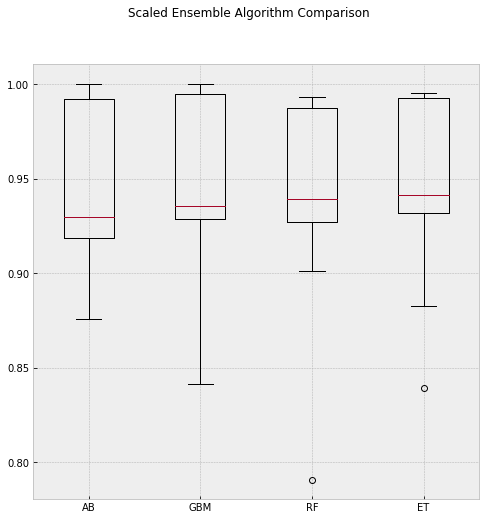

In [60]:
fig = plt.figure(figsize=(8,8))
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

The results suggest GBM and AdaBoost may be worthy of further study, with a strong mean and lower variance

#### Parameter tuning for GBM

In [ ]:
scaler = StandardScaler().fit(X_resampled)
rescaledX = scaler.transform(X_resampled)
param_grid = dict(n_estimators=numpy.array([50,100,150,200,250,300,350,400]))
GBMmodel = GradientBoostingRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
print("%f (%f) with: %r" % (mean, stdev, param))

#### Validation performance of GBM

In [62]:
scaler = StandardScaler().fit(X_resampled)
rescaledX = scaler.transform(X_resampled)
gbm_model = GradientBoostingClassifier(n_estimators=350)
gbm_model.fit(rescaledX, y_resampled)
rescaledValidationX = scaler.transform(X_validation)
predictions = gbm_model.predict(rescaledValidationX)
print('Accuracy:',accuracy_score(y_validation, predictions))
print()
print('Confusion matrix:\n', confusion_matrix(y_validation, predictions))
print()
print('Classification Report:\n', classification_report(y_validation,predictions))
print('ROC_AUC:', roc_auc_score(y_validation, predictions) )

Accuracy: 0.746226415094

Confusion matrix:
 [[580 204]
 [ 65 211]]

Classification Report:
              precision    recall  f1-score   support

          0       0.90      0.74      0.81       784
          1       0.51      0.76      0.61       276

avg / total       0.80      0.75      0.76      1060

ROC_AUC: 0.752144335995


#### Voting Ensemble

The idea behind the voting classifier implementation is to combine conceptually different machine learning classifiers
and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier
can be useful for a set of equally well performing model in order to balance out their individual weaknesses

In [65]:
from sklearn.ensemble import VotingClassifier
scaler = StandardScaler().fit(X_resampled)
rescaledX = scaler.transform(X_resampled)
ensemble = VotingClassifier(estimators=[('lr', logreg_model), ('svc', svc_model), ('gbm', gbm_model)],voting='soft')
ensemble.fit(rescaledX, y_resampled)
rescaledValidationX = scaler.transform(X_validation)
predictions = ensemble.predict(rescaledValidationX)
print('Accuracy:',accuracy_score(y_validation, predictions))
print()
print('Confusion matrix:\n', confusion_matrix(y_validation, predictions))
print()
print('Classification Report:\n', classification_report(y_validation,predictions))
print('ROC_AUC:', roc_auc_score(y_validation, predictions) )

Accuracy: 0.731132075472

Confusion matrix:
 [[548 236]
 [ 49 227]]

Classification Report:
              precision    recall  f1-score   support

          0       0.92      0.70      0.79       784
          1       0.49      0.82      0.61       276

avg / total       0.81      0.73      0.75      1060

ROC_AUC: 0.760721679976


The Logistic Regression model had the most superior performance for the metric of choice thus, i will save it for deployment

### Saving The Model

#### Save Model Using joblib

In [61]:
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
# save the model to disk
filename = 'models\churn_model.sav'
dump(logreg_model, filename)

['churn_model.sav']

### Making Submissions

#### Deriving prediction probabilities

In [63]:
np.set_printoptions(suppress=True, precision=3)
test_predictions = logreg_model.predict_proba(rescaled)

In [64]:
test_predictions

array([[ 0.946,  0.054],
       [ 0.999,  0.001],
       [ 0.964,  0.036],
       ..., 
       [ 0.952,  0.048],
       [ 0.992,  0.008],
       [ 0.994,  0.006]])

#### Appending prediction probabilities

In [65]:
not_churn = []
churn = []

for item in test_predictions:
    not_churn.append(item[0])
    churn.append(item[1])

In [85]:
test_df = pd.read_csv('data\Test.csv')

In [86]:
test_df.columns

Index(['CustomerID'], dtype='object')

In [88]:
submission = pd.DataFrame({
        "CustomerId": test_df["CustomerID"],
        "prob_not_churn": not_churn,
        "prob_churn" : churn
    })
submission.to_csv('data\submission.csv', index=False)


In [89]:
submission.head()

,CustomerId,prob_churn,prob_not_churn
0,Cust11201,0.053,0.947
1,Cust11202,0.001,0.999
2,Cust11203,0.036,0.964
3,Cust11204,0.981,0.019
4,Cust11205,0.898,0.102


Et Voila! You can see the probability of churning and not churning are now appended to each customerId.
Job well done!. This output has been writen to a file 'submission.csv' now in the current directory.

Of course there is still room for improvement, like doing a more extensive feature engineering, by comparing and plotting the features against each other and identifying and removing the noisy features. Another thing that can improve the overall result on the kaggle leaderboard would be a more extensive hyperparameter tuning on several machine learning models